In [1]:
from collections.abc import Callable
from functools import partial
from typing import Any, Literal, NewType
from warnings import warn

import astropy.table as at
import astropy.units as u
import jax
import jax.numpy as jnp
import numpy as np
import jax.typing as jtp
import jaxopt
import numpy.typing as npt
from gala.units import UnitSystem, galactic
from jax.scipy.special import gammaln
from jaxopt import Bisection
from jaxopt.base import OptStep
from typing_extensions import TypedDict

import inspect
from scipy.stats import binned_statistic
from torusimaging import data
from torusimaging.model_helpers import monotonic_quadratic_spline

from astropy.stats import median_absolute_deviation as MAD
from gala.units import UnitSystem
from scipy.stats import binned_statistic_2d
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData
from astropy.io import fits 
import tqdm
import cmasher as cm
import os
import model_radial

from torusimaging.jax_helpers import simpson
jax.config.update("jax_enable_x64", True)

In [2]:
# LOAD THE DATA
path = '/Users/dhortad/Documents/Data/allstar-dr17-StarHorse-Gaiadr3-astroNNages'
tb = fits.open(path)
data = tb[1].data 

# wmask = np.load('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-mask-all.npy',allow_pickle=True)

wmask = jnp.load('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-last.npy',allow_pickle=True)

print(len(data[wmask]))

77740


In [135]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi_deg = jnp.arctan(data['xyz'][:,1]/data['xyz'][:,0]) *(180./np.pi)
phi = jnp.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vR = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

In [136]:
vt = vt*u.km/u.s
vt = vt.to(u.kpc/u.Myr)

vR = vR*u.km/u.s
vR = vR.to(u.kpc/u.Myr)

vcirc = 229*u.km/u.s
vcirc = vcirc.to(u.kpc/u.Myr)

In [137]:
vR = vR.value
vt = vt.value
vcirc = vcirc.value

In [138]:
params = {
    'vcirc_delta': jnp.array([0.0]),
    'vR0': jnp.array([0.0]),
    'param_lnOmega0': jnp.array([-3.5]),
    'fourier_coeffs': {
        2: jnp.array([0.05]),
        4: jnp.array([0.05])
    }
}
dat = {'R': jnp.array(Rgal[wmask]), 'vphi': jnp.array(vt[wmask]), 'vR': jnp.array(vR[wmask]), 'label': jnp.array(data['MG_FE'][wmask]), 'vcirc_0': jnp.array(vcirc)}

vcirc = dat['vcirc_0'] + params['vcirc_delta']
pos = dat['R'] - (dat['R']*dat['vphi'])/vcirc
vel = dat['vR']

In [141]:
def jax_binned_statistic_2d(x, y, values, statistic='median', bins=[64, 64], rangos=[[-2,2], [-80,80]]):
    """
    Compute a 2D binned statistic (e.g., mean, sum, count) for the data.
    
    Parameters:
        x, y : array-like
            The coordinates of the data points.
        values : array-like
            The values at the corresponding (x, y) coordinates.
        statistic : str, optional
            The statistic to compute: 'mean', 'sum', 'count', etc.
        bins : int or array-like, optional
            The number of bins along each axis, or bin edges.
        range : tuple, optional
            The lower and upper bounds of the bins.

    Returns:
        binned_statistic : array
            The computed binned statistic.
    """

    if statistic == 'counts':
        counts, x_edges, y_edges = jnp.histogram2d(x, y, bins=64, range = [(-2,2), (-80,80)])
        return counts
    else:
        # Assign each point to a bin
        x_bin_idx = jnp.clip(jnp.digitize(pos, jnp.linspace(rangos[0][0], rangos[0][1], bins[0] + 1), right=True) - 1, 0, bins[0] - 1)
        y_bin_idx = jnp.clip(jnp.digitize(vel, jnp.linspace(rangos[1][0], rangos[1][1], bins[1] + 1), right=True) - 1, 0, bins[1] - 1)

        i_vals = jnp.arange(bins[0]) 
        j_vals = jnp.arange(bins[1]) 
        val = jnp.zeros((bins[0], bins[1]), dtype=float)

        if statistic == 'median':
            for idx, i in enumerate(i_vals):
                for jdx, j in enumerate(j_vals):
                    in_bin = (x_bin_idx == i) & (y_bin_idx == j)
                    selected = jnp.where(in_bin, values, jnp.nan)
                    if len(selected) > 0:
                        val = val.at[idx,jdx].set(jnp.nanmedian(selected))
                    else:
                        val = val.at[idx,jdx].set(jnp.nan)
            return val
        elif statistic == 'mean':
            for idx, i in enumerate(i_vals):
                for jdx, j in enumerate(j_vals):
                    in_bin = (x_bin_idx == i) & (y_bin_idx == j)
                    selected = jnp.where(in_bin, values, jnp.nan)
                    if len(selected) > 0:
                        val = val.at[idx,jdx].set(jnp.nanmean(selected))
                    else:
                        val = val.at[idx,jdx].set(jnp.nan)
            return val
        elif statistic == 'MAD':
            for idx, i in enumerate(i_vals):
                for jdx, j in enumerate(j_vals):
                    in_bin = (x_bin_idx == i) & (y_bin_idx == j)
                    selected = jnp.where(in_bin, values, jnp.nan)
                    if len(selected) > 0:
                        val = val.at[idx,jdx].set(jnp.nanmedian(jnp.abs(selected - jnp.nanmean(selected))))
                    else:
                        val = val.at[idx,jdx].set(jnp.nan)
            return val
        elif statistic == 'std':
            for idx, i in enumerate(i_vals):
                for jdx, j in enumerate(j_vals):
                    in_bin = (x_bin_idx == i) & (y_bin_idx == j)
                    selected = jnp.where(in_bin, values, jnp.nan)
                    if len(selected) > 0:
                        val = val.at[idx,jdx].set(jnp.nanstd(selected))
                    else:
                        val = val.at[idx,jdx].set(jnp.nan)
            return val


def calculate_mad(values):
    """Calculates the Mean Absolute Deviation (MAD) of a NumPy array.
    Args:
        values: A NumPy array of values.
    Returns:
        The MAD of the input array.
    """
    if len(values) == 0:
        return jnp.nan
    return jnp.mean(jnp.abs(values - jnp.mean(values)))

def bin_data(
            data,
            params,
            bins = [64,64],
            rangos = [[-2.,2.], [-80,80]]):

    """
    Function to bin the data into vR - (R-R_g) given kinematics and compute the label/label_err**2 value in each bin
    """

    
    vcirc = data['vcirc_0'] + params['vcirc_delta']
    pos = data['R'] - (data['R']*data['vphi'])/vcirc
    vel = data['vR']

    stat_mean = jax_binned_statistic_2d(
        pos,
        vel,
        data['label'],
        bins=bins,
        rangos = rangos,
        statistic='mean',
    )

    stat_counts = jax_binned_statistic_2d(
        pos,
        vel,
        data['label'],
        bins=bins,
        rangos = rangos,
        statistic='counts'
    )
    stat_mad = jax_binned_statistic_2d(
        pos,
        vel,
        data['label'],
        bins=bins,
        rangos = rangos,
        statistic='MAD',
    )
    
    err = (stat_mad * 1.5) / stat_counts
    xedges = jnp.linspace(rangos[0][0], rangos[0][1], bins[0]+1)
    yedges = jnp.linspace(rangos[1][0], rangos[1][1], bins[1]+1)
    X, Y = jnp.meshgrid(xedges, yedges, indexing='ij')

    return jnp.array(stat_mean), jnp.array(err), jnp.array(X), jnp.array(Y)
    

In [ ]:
params = {
    'vcirc_delta': jnp.array([0.0]),
    'vR0': jnp.array([0.0]),
    'param_lnOmega0': jnp.array([-3.5]),
    'fourier_coeffs': {
        2: jnp.array([0.05]),
        4: jnp.array([0.05])
    }
}

dat = {'R': jnp.array(Rgal[wmask]), 'vphi': jnp.array(vt[wmask]), 'vR': jnp.array(vR[wmask]), 'label': jnp.array(data['MG_FE'][wmask]), 'vcirc_0': jnp.array([229.0])}

vcirc = dat['vcirc_0'] + params['vcirc_delta']
pos = dat['R'] - (dat['R']*dat['vphi'])/vcirc
vel = dat['vR']

In [143]:
def fit_polynomial(x, y, deg):
    # Fit polynomial coefficients (least squares)
    X = jnp.vander(x, deg + 1)
    coeffs, *_ = jnp.linalg.lstsq(X, y, rcond=None)
    return coeffs

def eval_polynomial(coeffs, x):
    return jnp.polyval(coeffs, x)


In [159]:
from scipy.interpolate import CubicSpline
from jax import jit, vmap
    
def get_elliptical_coords(data, params):

    mean_label, err, X, Y = bin_data(data, params)

    delta_x = (X[:,0][1] - X[:,0][0])/2
    delta_y = (Y[:,1][0] - Y[:,0][0])/2
    X_  = (X[:-1,:-1] + delta_x)
    Y_  = (Y[:-1,:-1] + delta_y)

    pos = X_ * jnp.sqrt(jnp.exp(params['param_lnOmega0']))
    vel = Y_ / jnp.sqrt(jnp.exp(params['param_lnOmega0']))

    r_e = jnp.sqrt(pos**2 + vel**2)
    t_e = jnp.arctan2(vel, pos)
    
    return jnp.array(r_e), jnp.array(t_e), jnp.array(mean_label), jnp.array(err)
    
def get_rz(dat, params, smoothing=True, degree=2):
    """
    This function computes the distorted radius by adding Fourier distortions
    to the elliptical radius.
    """
    # Step 1: Get the elliptical coordinates (radius and angle)
    r_e, t_e, mean_label, err = get_elliptical_coords(dat, params)
    
    # Step 2: Initialize distortion term
    distortion = jnp.zeros_like(r_e)

    # Step 3: Apply Fourier distortion based on provided coefficients
    for m, e_m in params['fourier_coeffs'].items():
        distortion += e_m * jnp.cos(m * t_e)  # Apply Fourier mode distortion

    # Step 4: Compute the distorted radius
    distorted_radius = r_e * (1 + distortion)  # Apply distortion to the radius

    return jnp.array(distorted_radius)
        
def get_model_label(dat, params):

    r_e, t_e, mean_label, err = get_elliptical_coords(dat, params)
    
    clean_mean = jnp.nan_to_num(mean_label, nan=0.0)

    # Fit a polynomial (degree 2 or higher) to the data
    degree = 2
    coeffs = jnp.polyfit(r_e.ravel(), clean_mean.ravel(), degree)
    
    rz = get_rz(dat, params)

    # Evaluate the polynomial at the desired radius values
    rz_label = jnp.polyval(coeffs, rz)

    return jnp.array(rz_label)

def ln_gaussian_likelihood(params, data):

    r_e, t_e, mean_label, err = get_elliptical_coords(data, params)
    
    rz_label = get_model_label(data, params)    
    return -0.5 * jnp.nansum((mean_label - rz_label)**2/err**2)
    
def obj_gaussian(params, data):
    f_val = ln_gaussian_likelihood(params, data)
    return -f_val / data['label'].size

def optimize(params, data):

    optimiser = jaxopt.LBFGS(fun = obj_gaussian)
    res = optimiser.run(init_params = params, data = data)

    return res


In [ ]:
params = {
    'vcirc_delta': jnp.array([0.0]),
    'vR0': jnp.array([0.0]),
    'param_lnOmega0': jnp.array([-3.5]),
    'fourier_coeffs': {
        2: jnp.array([0.05]),
        4: jnp.array([0.05])
    }
}

mask_sun = (Rg>8)&(Rg<8.5)
dat = {'R': jnp.array(Rgal[wmask&mask_sun]), 'vphi': jnp.array(vt[wmask&mask_sun]), 'vR': jnp.array(vR[wmask&mask_sun]), 'label': jnp.array(data['MG_FE'][wmask&mask_sun]), 'vcirc_0': jnp.array([229.0])}

vcirc = dat['vcirc_0'] + params['vcirc_delta']
pos = dat['R'] - (dat['R']*dat['vphi'])/vcirc
vel = dat['vR']

(7068,)

In [ ]:
res = optimize(params, dat)


In [434]:
plt.figure(figsize=(16,6),facecolor='white')

# plt.subplot(1,2,1)
# plt.pcolormesh(r_e, t_e, mean)
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.pcolormesh(xnew, ynew, znew)
# plt.colorbar()

Array([-2.13661542, -1.89081014, -1.64500486, -1.39919958, -1.15339431,
       -0.90758903, -0.66178375, -0.41597847, -0.1701732 ,  0.07563208,
        0.32143736,  0.56724264,  0.81304792,  1.05885319,  1.30465847,
        1.55046375,  1.79626903,  2.0420743 ,  2.28787958,  2.53368486,
        2.77949014,  3.02529541,  3.27110069,  3.51690597,  3.76271125,
        4.00851653,  4.2543218 ,  4.50012708,  4.74593236,  4.99173764,
        5.23754291,  5.48334819,  5.72915347,  5.97495875,  6.22076402,
        6.4665693 ,  6.71237458,  6.95817986,  7.20398513,  7.44979041,
        7.69559569,  7.94140097,  8.18720625,  8.43301152,  8.6788168 ,
        8.92462208,  9.17042736,  9.41623263,  9.66203791,  9.90784319,
       10.15364847, 10.39945374, 10.64525902, 10.8910643 , 11.13686958,
       11.38267486, 11.62848013, 11.87428541, 12.12009069, 12.36589597,
       12.61170124, 12.85750652, 13.1033118 , 13.34911708, 13.59492235],      dtype=float64)

In [ ]:
# def get_rz(dat, params, orders= [2,4], fourier_coeffs=None):
params = {
    'vcirc_delta': 0.0,
    'vR0': 0.0,
    'param_lnOmega0': -3.0,
    'fourier_coeffs': {
        2: (0.05,),
        4: (0.05,)
    }
}
dat = {'R': Rgal[wmask], 'vphi': vt[wmask], 'vR': vR[wmask], 'label': data['MG_FE'][wmask], 'vcirc_0': 229.0}

def get_rz(dat, params, bins, rangos):
    # get the elliptical coords
    r_e, t_e = get_elliptical_coords(dat, params, bins= bins, rangos = rangos)
    
    distortion = np.zeros((len(params['fourier_coeffs'])))
    # add fourier distortion
    for m, e_m in params['fourier_coeffs'].items():
        distortion += np.nansum(e_m * np.cos(m*t_e.ravel()))
    
    return r_e + r_e * np.nansum(distortion)




NameError: name 'clean_mean' is not defined

In [492]:
# residual = mean_label - model
# plt.imshow(residual, cmap='coolwarm'); plt.colorbar()
model
# model.shape

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(64, 64))

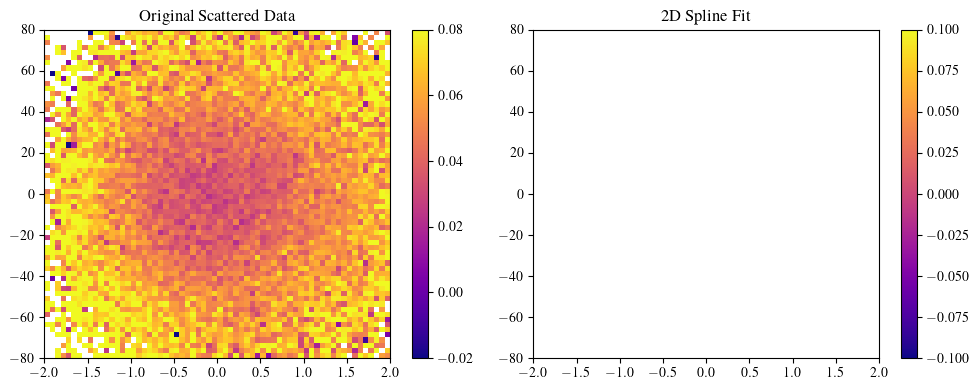

In [489]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.pcolormesh(X_, Y_, mean_label, cmap='plasma', vmin=-0.02, vmax=0.08)
plt.title("Original Scattered Data")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(X_, Y_, model, cmap='plasma')
plt.title("2D Spline Fit")
plt.colorbar()

plt.tight_layout()
plt.show()

In [88]:
def get_elliptical_coords(data, params, bins, rangos):

    mean_label, err, X, Y = bin_data(data, params, bins= bins, rangos = rangos)
    dim = int(len(X)/2)

    delta_x = (X[:,0][1] - X[:,0][0])/2
    delta_y = (Y[:,1][0] - Y[:,0][0])/2
    X_  = (X[dim:,0] + delta_x)*u.kpc
    Y_  = (Y[0,dim:] + delta_y)*u.km/u.s
    Y_ = Y_.to(u.kpc/u.Myr)
    Y_ 
    pos = X_.value * jnp.sqrt(jnp.exp(params['param_lnOmega0']))
    vel = Y_.value / jnp.sqrt(jnp.exp(params['param_lnOmega0']))

    r_e = jnp.sqrt(pos**2 + vel**2)
    t_e = jnp.arctan2(vel, pos)
    
    return r_e, t_e, mean_label, err, X, Y
    

In [89]:
r_e, t_e, mean_label, err_label, X, Y = get_elliptical_coords(dat, params, bins= bins, rangos = rangos)
r_e.shape, t_e.shape, mean_label.shape, X.shape

((33,), (33,), (64, 64), (65, 65))

In [140]:
from scipy.interpolate import UnivariateSpline
x_grid = np.linspace(0,0.6,128)
spline = UnivariateSpline(r_e, mean_label[31,31:].T, s=0.1)  # s controls smoothness; 0 means interpolation
y_fit = spline(x_grid)

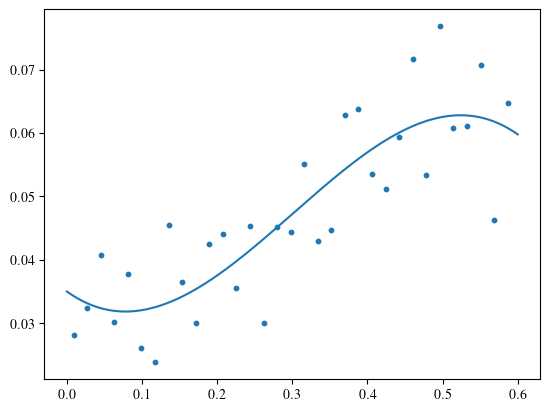

In [141]:
plt.scatter(r_e, mean_label[31,31:].T, s=10) # plot the trend in abundance with r_e for vR=0
plt.plot(x_grid, y_fit)

In [39]:
r = get_r(r_e, t_e)
r.shape, mean.shape

NameError: name 'get_r' is not defined

In [71]:
# create a Fourier expansion

# Build the design matrix
def fourier_basis_2d(X, Y, orders=[2, 4]):
    terms = [jnp.ones_like(X)]  # constant term
    for m in orders:
        for n in orders:
            terms += [
                jnp.cos(m*X) * jnp.cos(n*Y),
                # jnp.cos(m*X) * jnp.sin(n*Y),
                # jnp.sin(m*X) * jnp.cos(n*Y),
                # jnp.sin(m*X) * jnp.sin(n*Y),
            ]
    return jnp.stack(terms, axis=-1)
    
p = fourier_basis_2d(X[0,:-1,], Y[0,:-1])
p.shape, mean.shape
w = jnp.linalg.lstsq(p, mean)[0]


w

# Solve the least squares problem: w = (XᵀX)⁻¹ Xᵀ y
# w = jnp.linalg.lstsq(X, mean_label)[0]  # JAX 0.4.14+ supports lstsq like NumPy


Array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,  5.39497236e-02,
                    nan,  5.60516779e-02,  5.44004936e-02,
         5.28549179e-02,             nan,  5.18165051e-02,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
         4.78275849e-02,             nan,  5.13954121e-02,
                    nan,             nan,  4.89619481e-02,
                    nan,  5.21964822e-02,  5.15806119e-02,
                    nan,             nan,  4.97379226e-02,
                    nan,             nan,  5.60679995e-02,
                    nan,             nan,             nan,
                    nan,             nan,             na

In [456]:
def angular_fourier_basis(theta_e, modes=[2, 4]):
    X = [jnp.ones_like(theta_e)]  # constant term
    for m in modes:
        X.append(jnp.cos(m*theta_e))
    return jnp.column_stack(X)

def get_r(r_e, theta_e, modes=[2, 4]):

    X = angular_fourier_basis(theta_e, modes)
    coeffs, *_ = jnp.linalg.lstsq(X, r_e, rcond=None)

    modos = [0,2,4]
    r = r_e *( 1. + jnp.nansum(jnp.array([c * jnp.cos(modos[m]*theta_e) for m, c in enumerate(coeffs)]), axis=0))
    
    return r

In [415]:
def label_likelihood(data, params, bins, rangos):

    mean_label, mean_label_err, X, Y = bin_data(Rgal[wmask], vt[wmask], vR[wmask], 229., data['MG_FE'][wmask], data['MG_FE_ERR'][wmask], bins= bins, rangos = rangos)
    dim = int(len(X)/2)  
    
    r_e, theta_e = get_elliptical_coords(data['R'], data['vphi'], data['vR'], params['vcirc'], params['vR0'],\
                                         params['lnOmega0'], data['label'], data['label_err'], bins, rangos)

    r = get_r(r_e, t_e, modes=[2, 4])
    label_spline = UnivariateSpline(r, mean_label[dim][dim:], s=50)
    label_model = label_spline(r)

    return jnp.log((mean_label - label_model)**2/mean_label_err**2)

def objective_label(data, params, bins, rangos):
    return - label_likelihood(data, params, bins, rangos)

def optimise(params, data):
    
    optimizer = jaxopt.LBFGS(fun=objective_label, tol=1e-6, maxiter=3000, max_stepsize=1e3) # magic numbers

    res = optimizer.run(init_params = params, data = data)

    return res

In [416]:
res = optimise(params, data_)

TypeError: Dtype >f4 is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

In [92]:
r_e, t_e = TorusImaging1D_radial._get_elliptical_coords(Rgal[wmask], vt[wmask], vR[wmask], 229., 0.0,0.0,-3.)
r = TorusImaging1D_radial._get_r(r_e, t_e, )
e_params = {2: {'vals': jnp.array([-16., -16., -16., -16., -16., -16., -16.])},\
  4: {'vals': jnp.array([-16., -16., -16.])}}
e_params

ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'numpy.ndarray'>, [9.32188337 9.83149294 8.93331141 ... 5.93167839 5.0913289  5.91544049]. The error was:
TypeError: unhashable type: 'numpy.ndarray'


In [85]:
init_params = {'vcirc0': 0.0,
 'vel0': 0.0,
 'ln_Omega0': np.float64(-3.196417741080569),
 'e_params': {2: {'vals': jnp.array([-16., -16., -16., -16., -16., -16., -16.])},
  4: {'vals': jnp.array([-16., -16., -16.])}},
 'label_params': {'label_vals': jnp.array([0.0322193 , 0.11803584, 0.11803584, 0.11803584, 0.11803584,
         0.11803584, 0.11803584, 0.11803584])}}

In [88]:
model = TorusImaging1D_radial

In [90]:
r = model._get_r(r_e, t_e, init_params['e_params'], init_params['e_params'])

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute '_get_es'